In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

2022-12-13 19:52:16.036959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
PATH = 'content/lung_colon_image_set/lung_image_sets/'

IMAGE_CLASSES = os.listdir(PATH)

IMAGE_CLASSES

['lung_aca', 'lung_n', 'lung_scc']

### ACA = Adenocarcinomas
### N = Normal 
### SCC = Squamous Cell Carcinomas

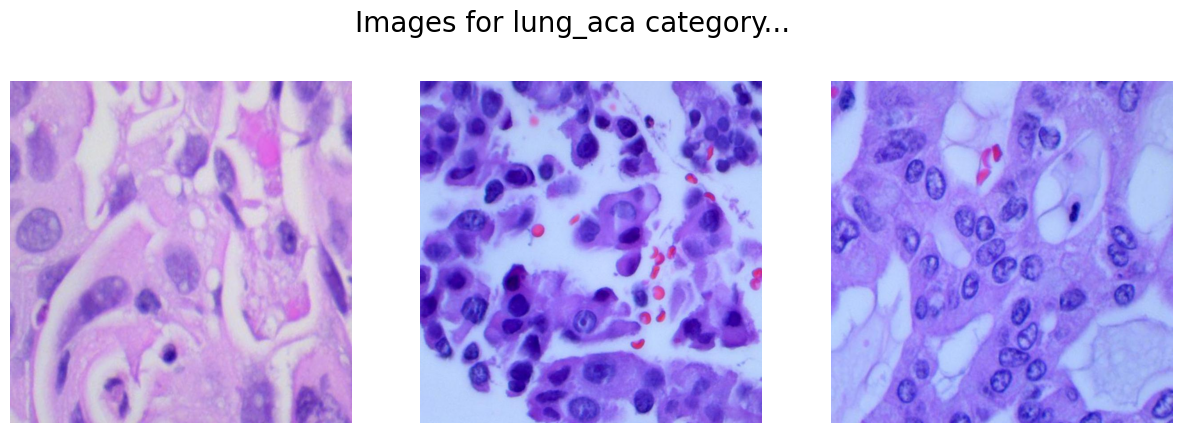

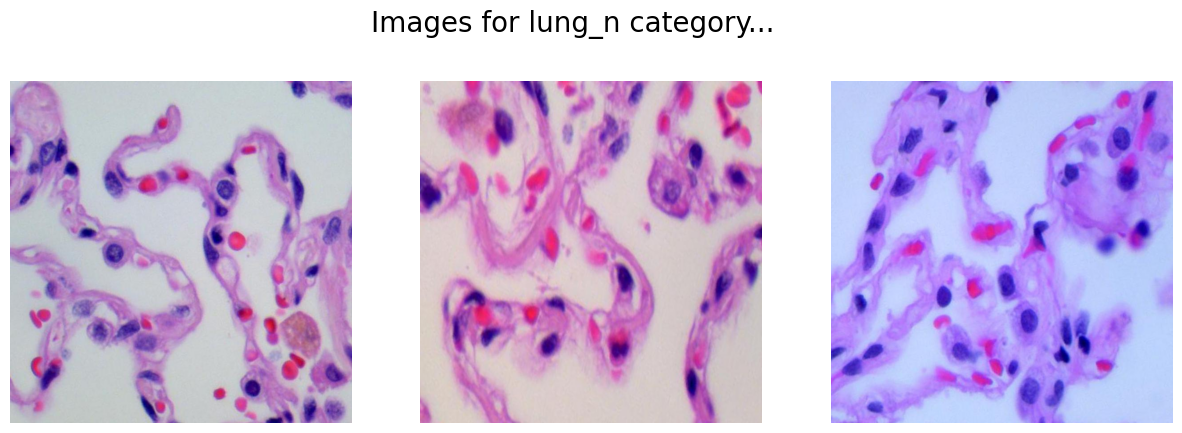

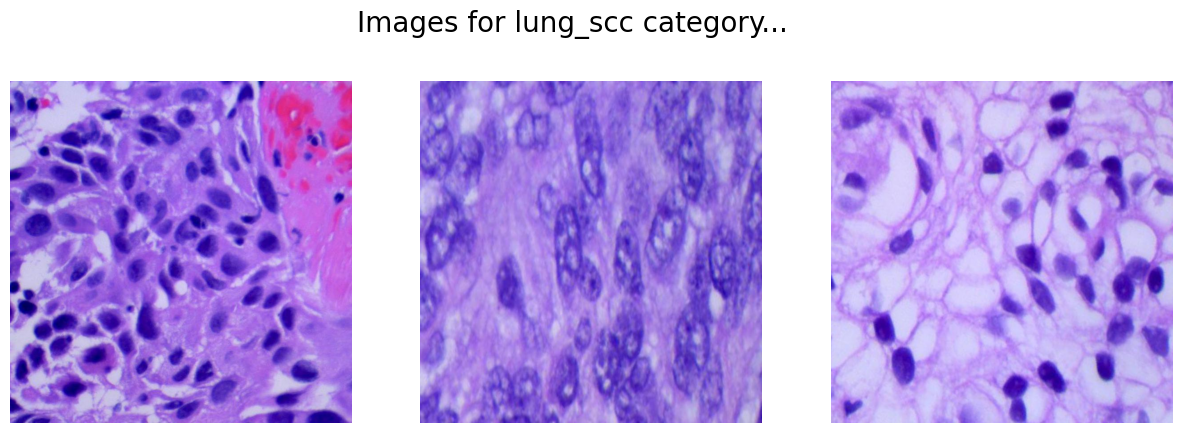

In [7]:
for category in IMAGE_CLASSES:
    image_directory = f'{PATH}/{category}'
    images = os.listdir(image_directory)
    
    figure, ax = plt.subplots(1, 3, figsize=(15, 5))
    figure.suptitle(f'Images for {category} category...', fontsize=20)
    
    for i in range(3):
        randon_image_number = np.random.randint(0, len(images))
        image = np.array(Image.open(f'{PATH}/{category}/{images[randon_image_number]}'))
        ax[i].imshow(image)
        ax[i].axis('off')
    plt.show()

### COMPUTER VISION CONSTANTS OR MODEL HYPERPARAMETERS

ML-DL Models are mathematical models usually with parameters that need to be learned from the data. This parameters are fit with existing data in the stage of training.

Hyperparameters, are parameters that cannot be learnt from training process. Those parameters indicate how the training process will be handled, if fastest or not, if we need to put performance over accuracy, etc.

### Hyperparameters Examples: 

* Penalty or C in Logistic Regression Classifier
* Learning rate for train a NN
* C and sigma for support vector machines
* K in the K-nearest neighbors

In [4]:
IMAGE_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

### SPLIT DATA AND ENCODING

#### One hot encoding

One hot encoding can be defined as the essential process of converting the categorical data variables to be provided to machine and deep learning algorithms which in turn improve predictions as well as classification accuracy of a model.

![One hot encoding](https://datagy.io/wp-content/uploads/2022/01/One-Hot-Encoding-for-Scikit-Learn-in-Python-Explained-1024x576.png)

In [5]:
X = []
Y = []

for i, category in enumerate(IMAGE_CLASSES):
    images = glob(f'{PATH}/{category}/*.jpeg')
    
    for image in images: 
        img = cv2.imread(image)
        
        X.append(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_y = pd.get_dummies(Y).values

#### Train data split


The Sklearn train_test_split function helps us create our training data and test data. This is because typically, the training data and test data come from the same original dataset. To get the data to build a model, we start with a single dataset, and then we split it into two datasets: train and test.

![Data split example](https://algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png)

In [6]:
x_train, x_value, y_train, y_value = train_test_split(X, one_hot_encoded_y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(x_train.shape, x_value.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


### CNN Model

In [7]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMAGE_SIZE,
                               IMAGE_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

2022-12-13 10:45:55.215416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### SUMMARY OF MODEL ARCHITECTURE

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

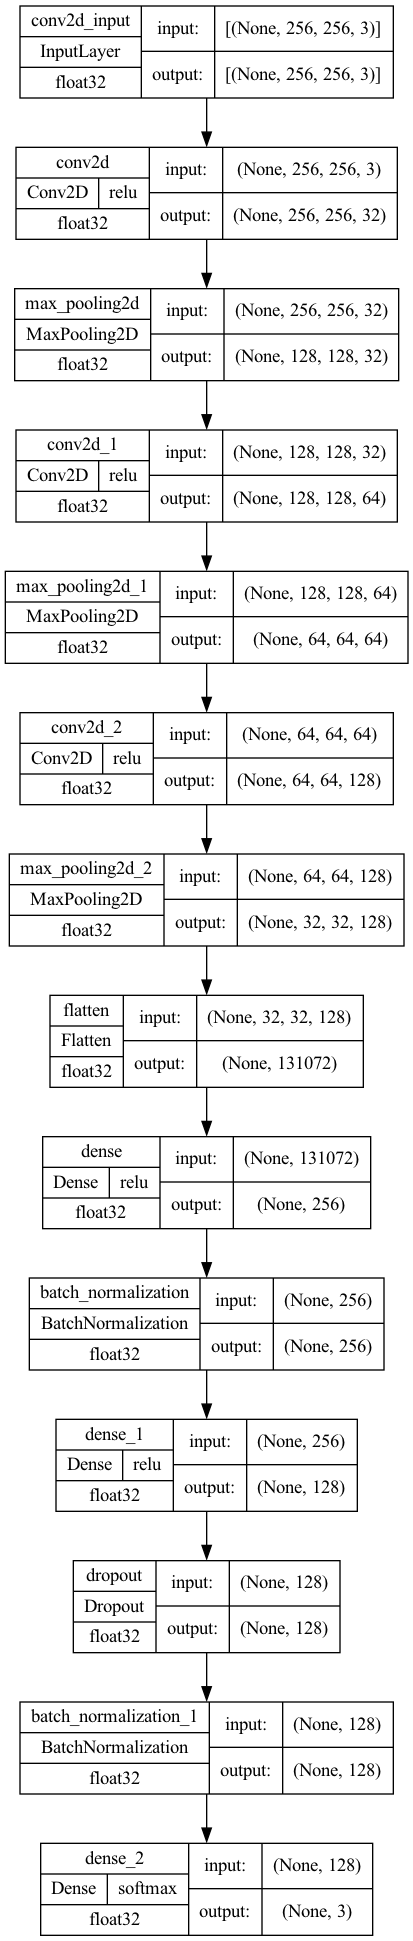

In [9]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
early_stopping = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
learning_rate = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [12]:
history = model.fit(x_train, y_train,
                    validation_data = (x_value, y_value),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [early_stopping, learning_rate, myCallback()])

Epoch 1/10
188/188 [==============================] - 722s 4s/step - loss: 0.3818 - accuracy: 0.8434 - val_loss: 20.1987 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 711s 4s/step - loss: 0.2286 - accuracy: 0.9095 - val_loss: 11.5932 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 690s 4s/step - loss: 0.1829 - accuracy: 0.9290 - val_loss: 2.5551 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 727s 4s/step - loss: 0.1454 - accuracy: 0.9422 - val_loss: 1.7408 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 736s 4s/step - loss: 0.1294 - accuracy: 0.9500 - val_loss: 4.1295 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 789s 4s/step - loss: 0.1054 - accuracy: 0.9603 - val_loss: 0.4599 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - 758s 4s/

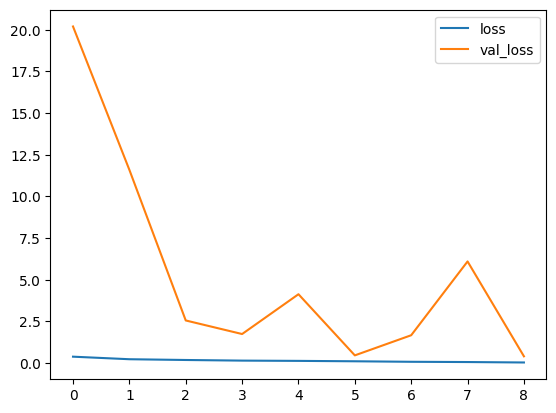

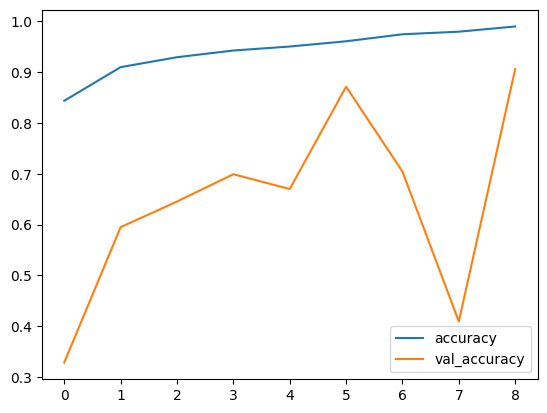

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [14]:
y_prediction = model.predict(x_value)
y_value = np.argmax(y_value, axis=1)
y_prediction = np.argmax(y_prediction, axis=1)

94/94 [==============================] - 49s 518ms/step


In [15]:
metrics.confusion_matrix(y_value, y_prediction)

array([[865,   0, 122],
       [ 87, 889,   1],
       [ 73,   0, 963]])

In [16]:
print(metrics.classification_report(y_value, y_prediction,
                                    target_names=IMAGE_CLASSES))

              precision    recall  f1-score   support

    lung_aca       0.84      0.88      0.86       987
      lung_n       1.00      0.91      0.95       977
    lung_scc       0.89      0.93      0.91      1036

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

